In [11]:
import os
# os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"
import sys
import torch
from torch.utils.data import random_split, DataLoader
import torch.optim as optim
import numpy as np
import torch.nn.functional as F
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import ReduceLROnPlateau
import wandb
import yaml
from scipy.fft import rfft

project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
if project_root not in sys.path:
    sys.path.append(project_root)

from lab_scripts.constellation_diagram import RingShapedConstellation, get_constellation, QPSK_Constellation
from modules.models import TCN_channel, TCN, memory_polynomial_channel, ABC_time_model
from modules.utils import *

In [12]:

# file_name = "channel_3e5-7.6MHz_2.68.V_0.125A_48mA_scale2_dynamic_power_0.5-3_v2.zarr"
# file_name = "channel_3e5-9.2MHz_2.775.V_0.129A_60ma_scale2_dynamic_power_0.5-3.zarr"
# file_name = "channel_3e5-10.8MHz_2.834V_0.135A_80mA_scale2_dynamic_power_0.5-3_v2.zarr"
# file_name = "channel_3e5-13MHz_2.934V_0.121A_121mA_scale2_dynamic_power_0.5-3_v2.zarr"
file_name = "channel_3e5-20MHz_2.739V_0.125A_47mA_scale2_dynamic_power_0.5-3_v2.zarr"

file_path = rf"..\data\channel_measurements\zarr_files\{file_name}"

if torch.cuda.is_available():
    DEVICE = torch.device("cuda")
elif hasattr(torch.backends, 'mps') and torch.backends.mps.is_available():
    DEVICE = torch.device("mps") # for M chip Macs
else:
    DEVICE = torch.device("cpu")
print("DEVICE", DEVICE)

ofdm_info = extract_zarr_data(file_path, DEVICE)
sent_frames_time = ofdm_info.sent_frames_time
received_frames_time = ofdm_info.received_frames_time
dataset = ChannelData(sent_frames_time, received_frames_time, ofdm_info.FREQUENCIES)

# Split sizes
train_size = int(0.9 * len(dataset))
 

val_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - val_size  # ensures total = 100%

# Perform split
TRAIN_DATASET, VAL_DATASET, TEST_DATASET = random_split(
    dataset,
    [train_size, val_size, test_size],
    generator=torch.Generator().manual_seed(42)
)
print("Train Size", train_size)

DEVICE cuda
Loaded from cache!
Train Size 2958


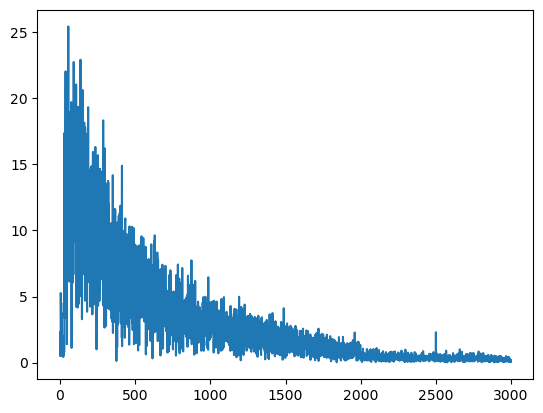

In [13]:
t = torch.fft.fft(received_frames_time[0, ofdm_info.CP_LENGTH:].cpu()).abs()
plt.plot(t[:len(t)//2])

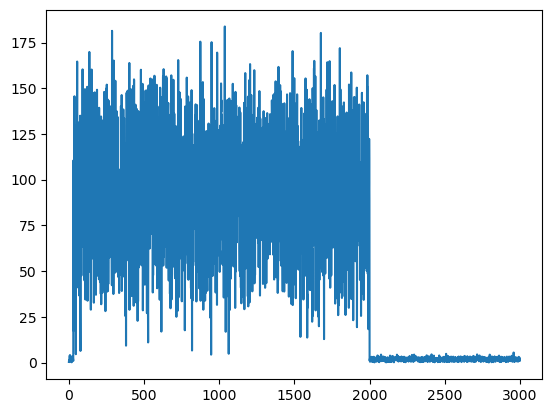

In [14]:
t = torch.fft.fft(sent_frames_time[0, ofdm_info.CP_LENGTH:].cpu()).abs()
plt.plot(t[:len(t)//2])

In [ ]:

def train(model, optimizer, loss_fn, loop, log_to_wandb=True):
    model.train()
    total_loss = 0
    batch_count = 0
    for batch in loop:
        x, y = batch[0], batch[1]
        x, y = x.to(DEVICE), y.to(DEVICE)
        optimizer.zero_grad()
        if model.learn_noise:
            noisy_y_pred, y_pred, y_pred_std, y_pred_nu = model(x)
        else:   
            y_pred = model(x)
        # calculate residual
        r = y - y_pred
        if model.learn_noise:
            if model.gaussian:
                loss = loss_fn(r, y_pred_std)
            else:
                loss = loss_fn(r, y_pred_std, y_pred_nu)
        else:
            loss = loss_fn(y, y_pred)

        mse_loss = F.mse_loss(y_pred, y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        lr = optimizer.param_groups[0]["lr"]
        if log_to_wandb:
            wandb.log({"nnl_train_loss": loss.item()})
            wandb.log({"mse_train_loss": mse_loss.item()})
            wandb.log({"learning_rate": lr})
        batch_count += 1
        loop.set_postfix(loss=loss.item())
    loop.close()

def val(model,
        loss_fn,
        val_loader,
        ofdm_info: OFDM_channel,
        memory_polynomial=None,
        log_to_wandb=True):
    model.eval()
    val_loss = 0
    batch_count = 0
    y_preds = []
    std_preds = []
    nu_preds = []
    true_ys = []
    noisy_ys = []
    val_mse_loss = 0
    rrmse_pct_loss = 0.0
    mse_mem_loss = 0.0

    with torch.no_grad():
        for x, y in val_loader:
            x = x.to(DEVICE)
            y = y.to(DEVICE)
            if model.learn_noise:
                noisy_y_pred, y_pred, y_pred_std, y_pred_nu = model(x)
                std_preds.append(y_pred_std)
                nu_preds.append(y_pred_nu)
                noisy_ys.append(noisy_y_pred)
            else:   
                y_pred = model(x)
            y_preds.append(y_pred)
            true_ys.append(y)

            if model.learn_noise:
                if model.gaussian:
                    loss = loss_fn(y - y_pred, y_pred_std) # Use mean for validation
                else:
                    loss = loss_fn(y - y_pred, y_pred_std, y_pred_nu) # Use mean for validation
            else:
                loss = loss_fn(y, y_pred)
            mse_loss = F.mse_loss(y, y_pred)

            rrmse_pct_loss += calculate_rrmse_pct_loss(y, y_pred)
            val_mse_loss += mse_loss.item()
            val_loss += loss.item()
            if memory_polynomial:
                y_pred_mp = memory_polynomial(x)
                mse_mem_loss += calculate_rrmse_pct_loss(y, y_pred_mp)
            batch_count += 1


    avg_val_loss = (val_loss / batch_count)
    avg_val_mse_loss = (val_mse_loss / batch_count)
    avg_val_mem_loss = (mse_mem_loss / batch_count)
    avg_nrmse_pct_loss = (rrmse_pct_loss / batch_count)

    y_preds = torch.vstack(y_preds)
    true_ys = torch.vstack(true_ys)
    residuals = true_ys - y_preds
    compute_billings_corrs(residuals, y_preds, lag_max=30, log_wandb=True, prefix="val_billings_corrs")


    if model.learn_noise:
        std_preds = torch.vstack(std_preds)
        nu_preds = torch.vstack(nu_preds)
        noisy_ys = torch.vstack(noisy_ys)

        avg_std = std_preds.mean().item()
        avg_nu = nu_preds.mean().item()
        if log_to_wandb:
            wandb.log({
                'avg_val_pred_std': avg_std,
            })
            if not model.gaussian:
                wandb.log({
                    'avg_val_pred_nu': avg_nu,
                })
    

    if log_to_wandb:
        # Log both scalar and histogram
        wandb.log({
            'val_nll_loss': avg_val_loss,
            "avg_val_mse_loss": avg_val_mse_loss,
            "avg_nrmse_pct_loss": avg_nrmse_pct_loss
        })
        if memory_polynomial:
            wandb.log({
                'val_mem_poly_nrmse_pct_loss': avg_val_mem_loss
            })
        if model.learn_noise:
            log_snr_plots(y_preds, noisy_ys, ofdm_info)

    return avg_val_loss, avg_nrmse_pct_loss

In [16]:
memory_polynomial = memory_polynomial_channel(weights=None, memory_linear=10, memory_nonlinear=10, nonlinearity_order=2, device=DEVICE)
train_indices = TRAIN_DATASET.indices
X_train = dataset.sent[train_indices].to(DEVICE)
y_train = dataset.received[train_indices].to(DEVICE)    
_, _, _ = memory_polynomial.fit(X_train, y_train)

In [17]:
memory_polynomial.calculate_err(X_train, y_train, plot=True)

del X_train, y_train

--------------------------------------------------
Rank  | Term String          | ERR (%)        
--------------------------------------------------
1     | x[0]                 | 35.443642%
2     | x[-1]                | 18.647850%
3     | x[-2]                | 18.105503%
4     | x[-4]                | 6.362188%
5     | x[-3]                | 5.689692%
6     | x[-5]                | 2.869045%
7     | x[-7]                | 1.598988%
8     | x[-6]                | 1.512209%
9     | x[-8]                | 0.621266%
10    | x[0]^2               | 0.468722%
11    | x[-9]                | 0.443559%
12    | x[-10]               | 0.418590%
13    | x[-2]^2              | 0.234427%
14    | x[-3]^2              | 0.185425%
15    | x[-4]^2              | 0.130712%
16    | x[-5]^2              | 0.105776%
17    | x[-6]^2              | 0.072040%
18    | x[-7]^2              | 0.043641%
19    | x[-8]^2              | 0.031650%
20    | x[-1]^2              | 0.020679%
21    | x[-9]^2             

In [18]:
def students_t_loss(difference, y_pred_std, y_pred_nu):
    nu = y_pred_nu
    z_resid = (difference) / (y_pred_std)
    term1 = -1 * torch.lgamma((nu + 1) / 2) + 0.5 * torch.log(torch.pi * nu) + torch.lgamma(nu / 2) + torch.log(y_pred_std + 1e-8)
    term2 = ((nu + 1) / 2) * torch.log(1 + (1 / nu) * torch.square(z_resid) + 1e-8)
    loss = torch.mean(term1 + term2)
    if torch.isnan(loss):
        raise ValueError("NaN in loss")
    return loss

def gaussian_nll(difference, y_pred_std):
    term1 = 0.5 * torch.log(2 * torch.pi * (y_pred_std ** 2))
    term2 = 0.5 * torch.square((difference) / y_pred_std)
    loss = torch.mean(term1 + term2)
    if torch.isnan(loss):
        raise ValueError("NaN in loss")
    return loss


def get_hyperparam_dict(name):
    script_dir = os.getcwd()
    config_path = os.path.join(script_dir, "..", f"configs/{name}")
    with open(config_path, "r") as f:
        hyper_dict = yaml.safe_load(f)
        return hyper_dict

def train_sweep():
    hyper_dict = get_hyperparam_dict("offline_time_channel_config.yml")
    
    hyper_dict['training_data'] = file_name
    hyper_dict['DELTA_K'] = ofdm_info.DELTA_K
    hyper_dict['K_MIN'] = ofdm_info.K_MIN
    hyper_dict['K_MAX'] = ofdm_info.K_MAX
    hyper_dict['Nf'] = len(ofdm_info.KS)

    run = wandb.init(project="mldrivenpeled", 
                     config=hyper_dict, 
                     tags=['channel_model', 'sweep'])
    config = wandb.config

    print(f"Run: {run.name} | LR: {config.lr}")

    train_loader = DataLoader(TRAIN_DATASET, shuffle=True, batch_size=config.batch_size, drop_last=False)
    val_loader = DataLoader(VAL_DATASET, shuffle=False, batch_size=config.batch_size, drop_last=False)

    channel_model = TCN_channel(
        nlayers=config.nlayers,
        dilation_base=config.dilation_base,
        num_taps=config.num_taps,
        hidden_channels=config.hidden_channels,
        learn_noise=config.learn_noise,
        gaussian=config.gaussian
    ).to(DEVICE)

    wandb.config.update({"num_params": channel_model.get_num_params()}, allow_val_change=True)
    
    if channel_model.learn_noise:
        if channel_model.gaussian:
            loss_fn = gaussian_nll
        else:
            loss_fn = students_t_loss
    else:
        loss_fn = F.mse_loss

    optimizer = optim.AdamW(
            channel_model.parameters(),
            lr=float(config.lr),
            weight_decay=float(config.wd)
        )

    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=1, min_lr=1e-6)

    epoch_counter = 0
    for epoch in range(config.epochs):
        epoch_counter += 1

        loop = tqdm(train_loader, desc=f'Epoch {epoch_counter}')
        train(channel_model,
                optimizer,
                loss_fn,
                loop)

        avg_val_loss, avg_nmrse_pct_loss = val(channel_model,
                                loss_fn,
                                val_loader,
                                memory_polynomial=memory_polynomial,
                                ofdm_info=ofdm_info)
        
        wandb.log({"val_loss": avg_val_loss, "epoch": epoch})

        scheduler.step(avg_val_loss)

    for param in channel_model.parameters():
        param.requires_grad = False

    torch.save({
        "channel_model": channel_model.state_dict(),
    }, "../models/channel_models/channel_model_final.pth")

    artifact = wandb.Artifact("channel_model", type="model")
    artifact.add_file("../models/channel_models/channel_model_final.pth")
    wandb.log_artifact(artifact)

    run.finish()

# sweep_configuration = {
#     'method': 'grid',
#     'metric': {'goal': 'minimize', 'name': 'val_loss'},
#     'parameters': {
#         'lr': {'values': [1e-3]},
#         'hidden_channels': {'values': [4, 8, 16]},
#         'nlayers': {'values': [2, 3, 4]},
#         'gaussian': {'values': [True, False]},
#         'num_taps': {'values': [10, 15]}
#     }
# }

# sweep_configuration = {
#     'method': 'grid',
#     'metric': {'goal': 'minimize', 'name': 'val_loss'},
#     'parameters': {
#         'lr': {'values': [1e-3]},
#         'hidden_channels': {'values': [8]},
#         'nlayers': {'values': [3]},
#         'gaussian': {'values': [False]},
#         'num_taps': {'values': [10]},
#         'learn_noise': {'values': [False]}
#     }
# }


sweep_configuration = {
    'method': 'grid',
    'metric': {'goal': 'minimize', 'name': 'val_loss'},
    'parameters': {
        'lr': {'values': [1e-3]},
        'hidden_channels': {'values': [16]},
        'nlayers': {'values': [4]},
        'gaussian': {'values': [False]},
        'num_taps': {'values': [10]},
        'learn_noise': {'values': [False]}
    }
}

sweep_id = wandb.sweep(sweep_configuration, project="mldrivenpeled")
wandb.agent(sweep_id, function=train_sweep)

Create sweep with ID: 2jk06l9s
Sweep URL: https://wandb.ai/dylanbackprops-university-of-washington/mldrivenpeled/sweeps/2jk06l9s


wandb: Agent Starting Run: ybxv0t7a with config:
wandb: 	gaussian: False
wandb: 	hidden_channels: 16
wandb: 	learn_noise: False
wandb: 	lr: 0.001
wandb: 	nlayers: 4
wandb: 	num_taps: 10
wandb: Currently logged in as: dylanbackprops (dylanbackprops-university-of-washington) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Run: honest-sweep-1 | LR: 0.001


Epoch 1: 100%|██████████| 185/185 [00:02<00:00, 81.00it/s, loss=0.00337] 
Traceback (most recent call last):
  File "c:\Users\maild\miniconda3\envs\mldrivenpeled\Lib\site-packages\wandb\agents\pyagent.py", line 297, in _run_job
    self._function()
  File "C:\Users\maild\AppData\Local\Temp\ipykernel_34624\3271176370.py", line 83, in train_sweep
    avg_val_loss, avg_nmrse_pct_loss = val(channel_model,
                                       ^^^^^^^^^^^^^^^^^^
  File "C:\Users\maild\AppData\Local\Temp\ipykernel_34624\2261215097.py", line 77, in val
    rrmse_pct_loss += calculate_rrmse_pct_loss(y, y_pred)
    ^^^^^^^^^^^^^^
UnboundLocalError: cannot access local variable 'rrmse_pct_loss' where it is not associated with a value

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mse_train_loss,█▆▇▇▄▃▃▂▃▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
nnl_train_loss,█▄▅▄▄▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
learning_rate,0.001
mse_train_loss,0.00337
nnl_train_loss,0.00337


wandb: ERROR Run ybxv0t7a errored: cannot access local variable 'rrmse_pct_loss' where it is not associated with a value
wandb: Sweep Agent: Waiting for job.
wandb: Ctrl + C detected. Stopping sweep.


In [ ]:
# Examine classical ABC model for comparison

from modules.models import ABC_time_model

# Run on CPU as it is recursive
DEVICE = torch.device("cpu")

train_loader = DataLoader(TRAIN_DATASET, shuffle=True, batch_size=32, drop_last=False)
val_loader = DataLoader(VAL_DATASET, shuffle=False, batch_size=32, drop_last=False)

channel_model = ABC_time_model().to(DEVICE)


def train_abc(model, optimizer, loss_fn, loop, subset_slice):
    model.train()
    total_loss = 0
    batch_count = 0
    for batch in loop:
        x, y = batch[0], batch[1]
        x, y = x.to(DEVICE), y.to(DEVICE)
        x = x[:, subset_slice]
        y = y[:, subset_slice]
        optimizer.zero_grad()
        y_pred = model(x)
        # calculate residual
        loss = loss_fn(y, y_pred)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        loop.set_postfix(loss=loss.item())
    loop.close()

def val_abc(
        model,
        loss_fn,
        val_loader,
        subset_slice):
    
    model.eval()
    val_loss = 0
    batch_count = 0
    y_preds = []
    true_ys = []
    rrmse_pct_loss = 0.0

    with torch.no_grad():
        for x, y in val_loader:
            x = x.to(DEVICE)
            y = y.to(DEVICE)
            x = x[:, subset_slice]
            y = y[:, subset_slice]
            y_pred = model(x)
            y_preds.append(y_pred)
            true_ys.append(y)

            loss = loss_fn(y, y_pred)

            rrmse_pct_loss += calculate_rrmse_pct_loss(y, y_pred)
            val_loss += loss.item()
            batch_count += 1


    avg_val_loss = (val_loss / batch_count)
    avg_rrmse_pct_loss = (rrmse_pct_loss / batch_count)

    return avg_val_loss, avg_rrmse_pct_loss


loss_fn = F.mse_loss

optimizer = optim.AdamW(
        channel_model.parameters(),
        lr=1e-3,
        weight_decay=1e-3
    )

scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=1, min_lr=1e-6)

epoch_counter = 0
for epoch in range(10):
    epoch_counter += 1

    loop = tqdm(train_loader, desc=f'Epoch {epoch_counter}')
    train_abc(channel_model,
            optimizer,
            loss_fn,
            loop,
        subset_slice=slice(0, 500))

    avg_val_loss, avg_rrmse_pct_loss = val_abc(
        channel_model,
            loss_fn,
            val_loader,
        subset_slice=slice(0, 500))
    print(f"Epoch {epoch_counter} | Val Loss: {avg_val_loss} | Val RRMSE% Loss: {avg_rrmse_pct_loss}")
    
    scheduler.step(avg_val_loss)

Epoch 1: 100%|██████████| 157/157 [00:17<00:00,  8.81it/s, loss=0.00393]


Epoch 1 | Val Loss: 0.003530602953914139 | Val RRMSE% Loss: 71.98208067152235


Epoch 2: 100%|██████████| 157/157 [00:18<00:00,  8.62it/s, loss=0.00251]


Epoch 2 | Val Loss: 0.0029061694836450946 | Val RRMSE% Loss: 65.29346720377605


Epoch 3: 100%|██████████| 157/157 [00:17<00:00,  8.78it/s, loss=0.00202]


Epoch 3 | Val Loss: 0.0023735399655480352 | Val RRMSE% Loss: 59.00083817376031


Epoch 4: 100%|██████████| 157/157 [00:18<00:00,  8.52it/s, loss=0.00213]


Epoch 4 | Val Loss: 0.002297726401593536 | Val RRMSE% Loss: 58.06525908576118


Epoch 5: 100%|██████████| 157/157 [00:18<00:00,  8.53it/s, loss=0.00203]


Epoch 5 | Val Loss: 0.002275185265009188 | Val RRMSE% Loss: 57.778715981377495


Epoch 6: 100%|██████████| 157/157 [00:17<00:00,  8.75it/s, loss=0.00253]


Epoch 6 | Val Loss: 0.002261675920130478 | Val RRMSE% Loss: 57.606458028157554


Epoch 7: 100%|██████████| 157/157 [00:18<00:00,  8.51it/s, loss=0.00226]


Epoch 7 | Val Loss: 0.002256457202343477 | Val RRMSE% Loss: 57.530011071099175


Epoch 8: 100%|██████████| 157/157 [00:18<00:00,  8.51it/s, loss=0.00277]


Epoch 8 | Val Loss: 0.002245094924647775 | Val RRMSE% Loss: 57.39028633965386


Epoch 9: 100%|██████████| 157/157 [00:18<00:00,  8.62it/s, loss=0.00236]


Epoch 9 | Val Loss: 0.0022356201532400316 | Val RRMSE% Loss: 57.25734435187446


Epoch 10: 100%|██████████| 157/157 [00:18<00:00,  8.70it/s, loss=0.00247]


Epoch 10 | Val Loss: 0.0022262383265317315 | Val RRMSE% Loss: 57.14130867852105
